In [1]:
#If imports do not work, make sure the python libraries are installed
#!pip install neurokit2
import neurokit2 as nk
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np 
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


2024-12-28 12:54:04.141487: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 12:54:04.872641: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 12:54:05.079807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735408445.540501 1042971 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735408445.600152 1042971 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 12:54:06.420510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
#combining all of the annotations datasets into one dataset
ppg_folder = './PPG_dataset/'
all_anots_files = [os.path.join(ppg_folder, f) for f in os.listdir(ppg_folder) if f.endswith('.csv') and "annotations" in os.path.basename(f)]
anots = pd.concat([pd.read_csv(file, delimiter=',') for file in all_anots_files], ignore_index=True)
anots.dataframeName = 'Annotations'

In [3]:
anots

,Datetime,Event,Value
0,2000-01-01T11:00:00,Stanford Sleepiness Self-Assessment (1-7),3
1,2000-01-01T12:00:00,Stanford Sleepiness Self-Assessment (1-7),1
2,2000-01-01T13:00:00,Stanford Sleepiness Self-Assessment (1-7),1
3,2000-01-01T14:00:00,Stanford Sleepiness Self-Assessment (1-7),1
4,2000-01-01T15:00:00,Stanford Sleepiness Self-Assessment (1-7),3
...,...,...,...
422,2000-01-02T09:27:00,Diary Entry (text),Hearthstone (G)
423,2000-01-02T10:03:00,Diary Entry (text),Thumper (G)
424,2000-01-02T10:19:00,Diary Entry (text),Dead Cells (G)
425,2000-01-02T10:41:00,Diary Entry (text),Dead Cells boss battle


In [4]:
#concatenating all of the ppg datasets
all_ppg_files = [os.path.join(ppg_folder, f) for f in os.listdir(ppg_folder) if f.endswith('.csv') and "ppg" in os.path.basename(f)]
all_dataframes = []
for file in all_ppg_files:
    dataframe_to_add = pd.read_csv(file)
    filename = os.path.basename(file)
    date_part = filename.split('-ppg-')[1].split('.csv')[0]
    dataframe_to_add['Time'] = date_part + " " + dataframe_to_add['Time']
    all_dataframes.append(dataframe_to_add)

ppg = pd.concat(all_dataframes , ignore_index=True)

In [5]:
ppg

,Time,Red_Signal
0,2000-01-01 12:59:28.589593,510.0
1,2000-01-01 12:59:28.589593,475.0
2,2000-01-01 12:59:28.590597,373.0
3,2000-01-01 12:59:28.590843,282.0
4,2000-01-01 12:59:28.590843,213.0
...,...,...
32000053,2000-01-01 23:59:52.436623,468.0
32000054,2000-01-01 23:59:52.452634,467.0
32000055,2000-01-01 23:59:52.452634,468.0
32000056,2000-01-01 23:59:52.468647,467.0


In [6]:
#converting the Time column and sorting the dataset based on time
ppg['Time'] = pd.to_datetime(ppg['Time'])
ppg.sort_values(by='Time', ascending=True, inplace=True)

In [7]:
#Calculating the sample rate
#Sample rate is needed for the ppg processing function
time1 = datetime.strptime(str(ppg.iloc[0]['Time']), '%Y-%m-%d %H:%M:%S.%f')
time2 = datetime.strptime(str(ppg.iloc[-2]['Time']), '%Y-%m-%d %H:%M:%S.%f')
difference = (time2 - time1).total_seconds()
sample_rate = len(ppg['Red_Signal']) / difference
print("Sample rate (samples per second):", sample_rate)

Sample rate (samples per second): 253.0289867368792


In [8]:
#Using neurokit2 to process the ppg data
signals, info = nk.ppg_process(ppg['Red_Signal'], sampling_rate=sample_rate)

#These lines of code can plot the signals in the dataset
#nk.ppg_plot(signals, info, static=True)
#nk.ppg_plot(signals, info, static=False)

/usr4/cs350rm/scadet/.local/lib/python3.11/site-packages/neurokit2/ppg/ppg_clean.py:73: NeuroKitWarning: There are 5 missing data points in your signal. Filling missing values using `signal_fillmissing`.
  warn(


In [9]:
signals

,PPG_Raw,PPG_Clean,PPG_Rate,PPG_Quality,PPG_Peaks
0,186.0,5.436250,61.514953,0.426059,0
1,529.0,14.061050,61.514953,0.426059,0
2,331.0,21.984516,61.514953,0.426059,0
3,471.0,28.560985,61.514953,0.426059,0
4,382.0,33.236738,61.514953,0.426059,0
...,...,...,...,...,...
32000053,470.0,0.778772,2.786151,0.646309,0
32000054,470.0,0.712355,2.786151,0.646309,0
32000055,469.0,0.649367,2.786151,0.646309,0
32000056,470.0,0.589459,2.786151,0.646309,0


In [10]:
#Adding time to the signals dataset
signals['Timestamp'] = ppg['Time']

In [11]:
#Formatting the time column in signals
signals['Timestamp'] = pd.to_datetime(signals['Timestamp'])
signals.set_index('Timestamp', inplace=True)

In [12]:
#Aggregating the dataset so there is one datapoint for every 100ms
per_second_df = signals.resample('100ms').agg({
    'PPG_Raw': 'mean',        # Average PPG_Raw per second
    'PPG_Clean': 'mean',      # Average cleaned PPG per second
    'PPG_Rate': 'mean',       # Average PPG rate per second
    'PPG_Quality': 'mean',    # Average quality per second
    'PPG_Peaks': 'sum'        # Total peaks per second
})
per_second_df.dropna(inplace=True)
signals = per_second_df

In [13]:
#Formatting the time column in annotations dataset
anots['Timestamp'] = pd.to_datetime(anots['Datetime'])
anots.drop('Datetime', axis=1, inplace=True)

In [14]:
anots.dtypes

Event                object
Value                object
Timestamp    datetime64[ns]
dtype: object

In [15]:
anots

,Event,Value,Timestamp
0,Stanford Sleepiness Self-Assessment (1-7),3,2000-01-01 11:00:00
1,Stanford Sleepiness Self-Assessment (1-7),1,2000-01-01 12:00:00
2,Stanford Sleepiness Self-Assessment (1-7),1,2000-01-01 13:00:00
3,Stanford Sleepiness Self-Assessment (1-7),1,2000-01-01 14:00:00
4,Stanford Sleepiness Self-Assessment (1-7),3,2000-01-01 15:00:00
...,...,...,...
422,Diary Entry (text),Hearthstone (G),2000-01-02 09:27:00
423,Diary Entry (text),Thumper (G),2000-01-02 10:03:00
424,Diary Entry (text),Dead Cells (G),2000-01-02 10:19:00
425,Diary Entry (text),Dead Cells boss battle,2000-01-02 10:41:00


In [16]:
#extracting only the sleepiness assessments from the dataset into its own dataset
sleepiness = anots.loc[anots['Event'] == 'Stanford Sleepiness Self-Assessment (1-7)']
sleepiness = sleepiness.reset_index().drop('index',axis=1)
sleepiness = pd.DataFrame({'Timestamp' : sleepiness['Timestamp'], 'Stanford Sleepiness Self-Assessment (1-7)' : sleepiness['Value']})
sleepiness.sort_values('Timestamp', inplace=True)

In [17]:
sleepiness['Stanford Sleepiness Self-Assessment (1-7)'].value_counts()

Stanford Sleepiness Self-Assessment (1-7)
1    38
2    37
3    26
4    13
5     9
6     1
7     1
Name: count, dtype: int64

In [18]:
sleepiness

,Timestamp,Stanford Sleepiness Self-Assessment (1-7)
0,2000-01-01 11:00:00,3
100,2000-01-01 11:00:00,1
25,2000-01-01 11:00:00,3
75,2000-01-01 11:00:00,1
50,2000-01-01 11:00:00,3
...,...,...
74,2000-01-02 11:00:00,3
49,2000-01-02 11:00:00,2
24,2000-01-02 11:00:00,5
99,2000-01-02 11:00:00,2


In [19]:
# Extracting only the reaction times from the dataset into its own 
reaction_times = anots.loc[anots['Event'] == 'Sleep-2-Peak Reaction Time (ms)']
reaction_times = reaction_times.reset_index().drop('index',axis=1)
reaction_times.sort_values('Timestamp', inplace=True)
reaction_times = reaction_times.reset_index().drop('index',axis=1)
reaction_times = pd.DataFrame({'Timestamp' : reaction_times['Timestamp'], 'Sleep-2-Peak Reaction Time' : reaction_times['Value']})
reaction_times

,Timestamp,Sleep-2-Peak Reaction Time
0,2000-01-01 11:02:00,296
1,2000-01-01 11:03:00,281
2,2000-01-01 11:03:00,273
3,2000-01-01 11:03:00,335
4,2000-01-01 11:04:00,323
...,...,...
116,2000-01-02 10:02:00,302
117,2000-01-02 10:04:00,303
118,2000-01-02 11:02:00,243
119,2000-01-02 11:03:00,305


In [20]:
# Merge the `signals` DataFrame sequentially with the `reaction_times` and `sleepiness` DataFrames by aligning rows based on the nearest 'Timestamp'.
signals = pd.merge_asof(signals.sort_values('Timestamp'), reaction_times.sort_values('Timestamp'), on='Timestamp', direction='nearest')
signals = pd.merge_asof(signals.sort_values('Timestamp'), sleepiness.sort_values('Timestamp'), on='Timestamp', direction='nearest')

In [21]:
signals

,Timestamp,PPG_Raw,PPG_Clean,PPG_Rate,PPG_Quality,PPG_Peaks,Sleep-2-Peak Reaction Time,Stanford Sleepiness Self-Assessment (1-7)
0,2000-01-01 00:00:00.000,544.750000,-29.655647,51.049933,0.799218,0,296,3
1,2000-01-01 12:52:02.900,490.976000,9.247778,46.042789,0.276185,0,291,1
2,2000-01-01 12:52:03.000,458.108108,-20.224100,36.972107,0.707269,1,291,1
3,2000-01-01 12:52:03.100,501.160550,15.604114,36.099978,0.544007,0,291,1
4,2000-01-01 12:52:03.200,457.308594,-18.499108,46.531788,0.155008,1,291,1
...,...,...,...,...,...,...,...,...
737363,2000-01-02 11:07:47.500,441.777778,-1.198460,55.015078,0.657634,0,250,4
737364,2000-01-02 11:07:47.600,441.166667,5.155274,54.401367,0.628078,0,250,4
737365,2000-01-02 11:07:47.700,469.333333,12.810990,53.777331,0.596824,0,250,4
737366,2000-01-02 11:07:47.800,449.300000,5.201394,53.208520,0.566960,0,250,4


In [22]:
#getting the number of unique values in signals
for col in signals:
    print(col, ":", signals[col].nunique())

Timestamp : 737368
PPG_Raw : 113769
PPG_Clean : 737368
PPG_Rate : 737353
PPG_Quality : 737368
PPG_Peaks : 5
Sleep-2-Peak Reaction Time : 64
Stanford Sleepiness Self-Assessment (1-7) : 6


In [26]:
#distributions of the sleepiness values
signals['Stanford Sleepiness Self-Assessment (1-7)'].value_counts()

Stanford Sleepiness Self-Assessment (1-7)
2    234993
3    188521
1    165178
4     76678
5     53999
7     17999
Name: count, dtype: int64

In [27]:
signals.dtypes

Timestamp                                    datetime64[ns]
PPG_Raw                                             float64
PPG_Clean                                           float64
PPG_Rate                                            float64
PPG_Quality                                         float64
PPG_Peaks                                             int64
Sleep-2-Peak Reaction Time                           object
Stanford Sleepiness Self-Assessment (1-7)            object
dtype: object

In [28]:
#converting 'Sleepiness' to integer
to_convert = [col for col in signals if 'Sleepiness' in col]
signals[to_convert] = signals[to_convert].astype(int)


In [29]:
#converting reaction times to int
signals['Sleep-2-Peak Reaction Time'] = signals['Sleep-2-Peak Reaction Time'].astype(int)

In [30]:
signals

,Timestamp,PPG_Raw,PPG_Clean,PPG_Rate,PPG_Quality,PPG_Peaks,Sleep-2-Peak Reaction Time,Stanford Sleepiness Self-Assessment (1-7)
0,2000-01-01 00:00:00.000,544.750000,-29.655647,51.049933,0.799218,0,296,3
1,2000-01-01 12:52:02.900,490.976000,9.247778,46.042789,0.276185,0,291,1
2,2000-01-01 12:52:03.000,458.108108,-20.224100,36.972107,0.707269,1,291,1
3,2000-01-01 12:52:03.100,501.160550,15.604114,36.099978,0.544007,0,291,1
4,2000-01-01 12:52:03.200,457.308594,-18.499108,46.531788,0.155008,1,291,1
...,...,...,...,...,...,...,...,...
737363,2000-01-02 11:07:47.500,441.777778,-1.198460,55.015078,0.657634,0,250,4
737364,2000-01-02 11:07:47.600,441.166667,5.155274,54.401367,0.628078,0,250,4
737365,2000-01-02 11:07:47.700,469.333333,12.810990,53.777331,0.596824,0,250,4
737366,2000-01-02 11:07:47.800,449.300000,5.201394,53.208520,0.566960,0,250,4


In [31]:
signals.dtypes

Timestamp                                    datetime64[ns]
PPG_Raw                                             float64
PPG_Clean                                           float64
PPG_Rate                                            float64
PPG_Quality                                         float64
PPG_Peaks                                             int64
Sleep-2-Peak Reaction Time                            int64
Stanford Sleepiness Self-Assessment (1-7)             int64
dtype: object

In [32]:
#splitting timestamp into individual columns
signals['Year'] = signals['Timestamp'].dt.year
signals['Month'] = signals['Timestamp'].dt.month
signals['Day'] = signals['Timestamp'].dt.day
signals['Hour'] = signals['Timestamp'].dt.hour
signals['Minute'] = signals['Timestamp'].dt.minute
signals['Second'] = signals['Timestamp'].dt.second
signals['Microsecond'] = signals['Timestamp'].dt.microsecond

In [33]:
signals

,Timestamp,PPG_Raw,PPG_Clean,PPG_Rate,PPG_Quality,PPG_Peaks,Sleep-2-Peak Reaction Time,Stanford Sleepiness Self-Assessment (1-7),Year,Month,Day,Hour,Minute,Second,Microsecond
0,2000-01-01 00:00:00.000,544.750000,-29.655647,51.049933,0.799218,0,296,3,2000,1,1,0,0,0,0
1,2000-01-01 12:52:02.900,490.976000,9.247778,46.042789,0.276185,0,291,1,2000,1,1,12,52,2,900000
2,2000-01-01 12:52:03.000,458.108108,-20.224100,36.972107,0.707269,1,291,1,2000,1,1,12,52,3,0
3,2000-01-01 12:52:03.100,501.160550,15.604114,36.099978,0.544007,0,291,1,2000,1,1,12,52,3,100000
4,2000-01-01 12:52:03.200,457.308594,-18.499108,46.531788,0.155008,1,291,1,2000,1,1,12,52,3,200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737363,2000-01-02 11:07:47.500,441.777778,-1.198460,55.015078,0.657634,0,250,4,2000,1,2,11,7,47,500000
737364,2000-01-02 11:07:47.600,441.166667,5.155274,54.401367,0.628078,0,250,4,2000,1,2,11,7,47,600000
737365,2000-01-02 11:07:47.700,469.333333,12.810990,53.777331,0.596824,0,250,4,2000,1,2,11,7,47,700000
737366,2000-01-02 11:07:47.800,449.300000,5.201394,53.208520,0.566960,0,250,4,2000,1,2,11,7,47,800000


In [34]:
#Renaming sleepiness column
signals['Sleepiness'] = signals['Stanford Sleepiness Self-Assessment (1-7)']
signals = signals.drop('Stanford Sleepiness Self-Assessment (1-7)', axis=1)

In [35]:
signals

,Timestamp,PPG_Raw,PPG_Clean,PPG_Rate,PPG_Quality,PPG_Peaks,Sleep-2-Peak Reaction Time,Year,Month,Day,Hour,Minute,Second,Microsecond,Sleepiness
0,2000-01-01 00:00:00.000,544.750000,-29.655647,51.049933,0.799218,0,296,2000,1,1,0,0,0,0,3
1,2000-01-01 12:52:02.900,490.976000,9.247778,46.042789,0.276185,0,291,2000,1,1,12,52,2,900000,1
2,2000-01-01 12:52:03.000,458.108108,-20.224100,36.972107,0.707269,1,291,2000,1,1,12,52,3,0,1
3,2000-01-01 12:52:03.100,501.160550,15.604114,36.099978,0.544007,0,291,2000,1,1,12,52,3,100000,1
4,2000-01-01 12:52:03.200,457.308594,-18.499108,46.531788,0.155008,1,291,2000,1,1,12,52,3,200000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737363,2000-01-02 11:07:47.500,441.777778,-1.198460,55.015078,0.657634,0,250,2000,1,2,11,7,47,500000,4
737364,2000-01-02 11:07:47.600,441.166667,5.155274,54.401367,0.628078,0,250,2000,1,2,11,7,47,600000,4
737365,2000-01-02 11:07:47.700,469.333333,12.810990,53.777331,0.596824,0,250,2000,1,2,11,7,47,700000,4
737366,2000-01-02 11:07:47.800,449.300000,5.201394,53.208520,0.566960,0,250,2000,1,2,11,7,47,800000,4


In [36]:
#Splitting the dataset into features and target columns
features = ['PPG_Raw', 'PPG_Clean', 'PPG_Rate', 'PPG_Quality', 'PPG_Peaks', 'Sleep-2-Peak Reaction Time', 'Year',	'Month',	'Day',	'Hour',	'Minute',	'Second',	'Microsecond']
target = 'Sleepiness'

X = signals[features]
y = signals[target]
X.shape

(737368, 13)

In [37]:
signals['Sleepiness'].unique()

array([3, 1, 2, 4, 5, 7])

In [38]:
#Function for creating the sliding windows
#Train_size and test_size is the amount of windows that are created for training or testing before switching
# to the other kind of window 
def create_intermittent_train_test(features, labels, window_size, train_size, test_size, step=1):
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    i = 0
    while i + window_size <= len(features):
        # Collect training windows
        for _ in range(train_size):
            if i + window_size > len(features):
                break
            X_train.append(features.iloc[i: i + window_size].values)
            y_train.append(labels.iloc[i + window_size - 1]) 
            i += step
        
        # Collect testing windows
        for _ in range(test_size):
            if i + window_size > len(features):
                break
            X_test.append(features.iloc[i: i + window_size].values)
            y_test.append(labels.iloc[i + window_size - 1])
            i += step
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)



In [39]:
signals.dropna()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = create_intermittent_train_test(X, y, 10, 2, 1, 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.unique(y_train))
print(np.unique(y_test))

(49158, 10, 13)
(24578, 10, 13)
(49158,)
(24578,)
[1 2 3 4 5 7]
[1 2 3 4 5 7]


In [40]:
# Normalize the data
scaler = StandardScaler()
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

#Restore shape
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], n_features)

print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_test shape:", X_test_scaled.shape)

Scaled X_train shape: (49158, 10, 13)
Scaled X_test shape: (24578, 10, 13)


In [41]:
signals['Sleepiness'].unique()

array([3, 1, 2, 4, 5, 7])

In [42]:
model = tf.keras.Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))

# Flatten the output of the convolution
model.add(Flatten())

# Dense  layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

#Drop 2% to prevent overfitting
model.add(Dropout(0.02))

model.add(Dense(7, activation='softmax'))


model.compile(optimizer='adam',  loss='categorical_crossentropy', metrics=['accuracy', 'mae'])

model.summary()



/usr4/cs350rm/scadet/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-28 13:12:15.473854: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,183 (71.03 KB)

 Trainable params: 18,183 (71.03 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
print(X_train_scaled.shape)  # Check shape
print(y_train.shape) 
print(type(X_train_scaled))  # Ensure it's a NumPy array
print(type(y_train))     
print(X_train_scaled.dtype)
print(y_train.dtype)


(49158, 10, 13)
(49158,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
float64
int64


In [44]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.dtype) for l in model.layers]

(None, 10, 13) float32
(None, 7) float32
conv1d float32
flatten float32
dense float32
dropout float32
dense_1 float32


[None, None, None, None, None]

In [46]:
#Adjusting the label values to be 0-index based so that to_categorical works
y_train_adjusted = y_train - 1

y_train_encoded = to_categorical(y_train_adjusted, num_classes=7)
print(y_train)

[1 1 1 ... 4 4 4]


In [47]:
# Train the model
model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=80, validation_split=0.2)

Epoch 1/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5262 - loss: 1.0968 - mae: 0.1713 - val_accuracy: 0.1395 - val_loss: 6.7319 - val_mae: 0.2418
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8643 - loss: 0.3990 - mae: 0.0758 - val_accuracy: 0.1084 - val_loss: 10.3970 - val_mae: 0.2468
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9449 - loss: 0.1950 - mae: 0.0385 - val_accuracy: 0.1358 - val_loss: 13.4598 - val_mae: 0.2400
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9626 - loss: 0.1279 - mae: 0.0250 - val_accuracy: 0.2033 - val_loss: 15.4592 - val_mae: 0.2277
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9708 - loss: 0.0957 - mae: 0.0183 - val_accuracy: 0.2035 - val_loss: 16.5790 - val_mae: 0.2230
Epoch 6/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9784 - loss: 0.0737 - mae: 0.0139 - val_accuracy: 0.2229 - val_loss: 18.3485 - val_mae: 0.2180
Epoch 7/10
492/492 ━━━━━━━━━━━━━━━━

In [48]:
# Evaluate the model on the test data
y_test_adjusted = y_test - 1
y_test_encoded = to_categorical(y_test_adjusted, num_classes=7)
model.evaluate(X_test_scaled, y_test_encoded)


769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9758 - loss: 0.6638 - mae: 0.0107


[4.9032206535339355, 0.8580437898635864, 0.04510103538632393]

In [50]:
# Get predictions
y_pred = model.predict(X_test_scaled)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class indices (if not already in this format)
y_true_classes = np.argmax(y_test_encoded, axis=1)


769/769 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [51]:
class_labels = [0, 1, 2, 3, 4, 5, 6]


# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=class_labels)
print(cm)


[[5422   29   54    0    0    0    0]
 [   1 6595  545    0  162    0  530]
 [   3    2 6124    0  154    0    1]
 [   0    4  659  589 1269    0   35]
 [   0   20    1    0 1768    0   11]
 [   0    0    0    0    0    0    0]
 [   0    9    0    0    0    0  591]]


/scratch/1670858.1.rnaseq-pub/ipykernel_1042971/1507562435.py:5: RuntimeWarning: invalid value encountered in divide
  accuracy_percentages = np.diag(cm) / np.sum(cm, axis=1) * 100


Accuracy for class 1: 98.49%
Accuracy for class 2: 84.20%
Accuracy for class 3: 97.45%
Accuracy for class 4: 23.04%
Accuracy for class 5: 98.22%
Accuracy for class 6: nan%
Accuracy for class 7: 98.50%


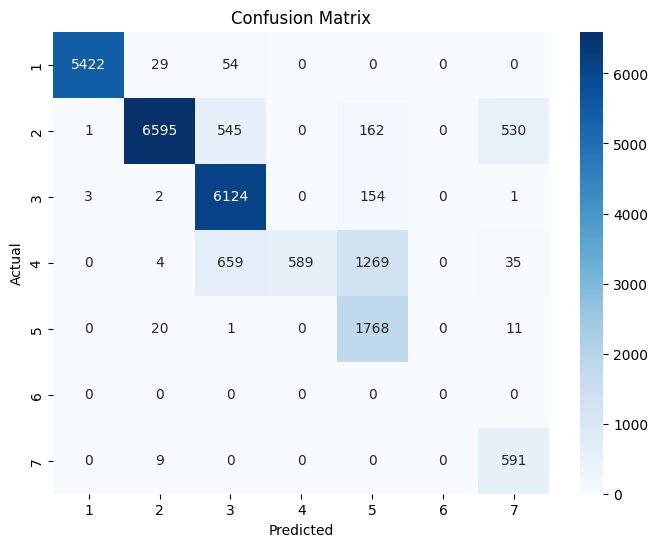

In [52]:


# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", yticklabels=np.array(class_labels) + 1, xticklabels=np.array(class_labels) + 1)
# Calculate accuracy percentages for each class
accuracy_percentages = np.diag(cm) / np.sum(cm, axis=1) * 100

# Print accuracy percentages for each class
for i in range(len(class_labels)):
    print(f"Accuracy for class {i + 1}: {accuracy_percentages[i]:.2f}%")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
